# Index

1. [Libraries](#Libraries)
2. [Getting Started](#Data)
3. [EDA](#Exploratory-Data-Analysis)
4. [Getting ready](#Preprocessing)
5. [Making some predictions](#Modeling)
6. [Looking for best model](#Tuning)
7. [Time for a boost](#Ensemble)


NOTE: This index contains links to the various sections of the notebook for an easier and faster navigation.

<h2>Libraries<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
#Basics
import pandas as pd
import numpy as np
from statistics import mode

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import PercentFormatter

#Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

#Regressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

#Grid Search
import optuna

#Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import max_error, mean_absolute_percentage_error,r2_score

#Extras
import warnings
from tqdm.auto import tqdm
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

warnings.filterwarnings('ignore')

<h2>Data<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
df = pd.read_csv("housing-2.csv")
print("\033[1m{} rows and {} features\033[0m".format(df.shape[0],df.shape[1]))
df.head()

20640 rows and 10 features


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
round(df.describe(),2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


Looking for null values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There aren't null values, good start.

Two lists containing feature names' based on variable type will be created to make preprocessing easier, so we'll get nominal and numeric features lists.

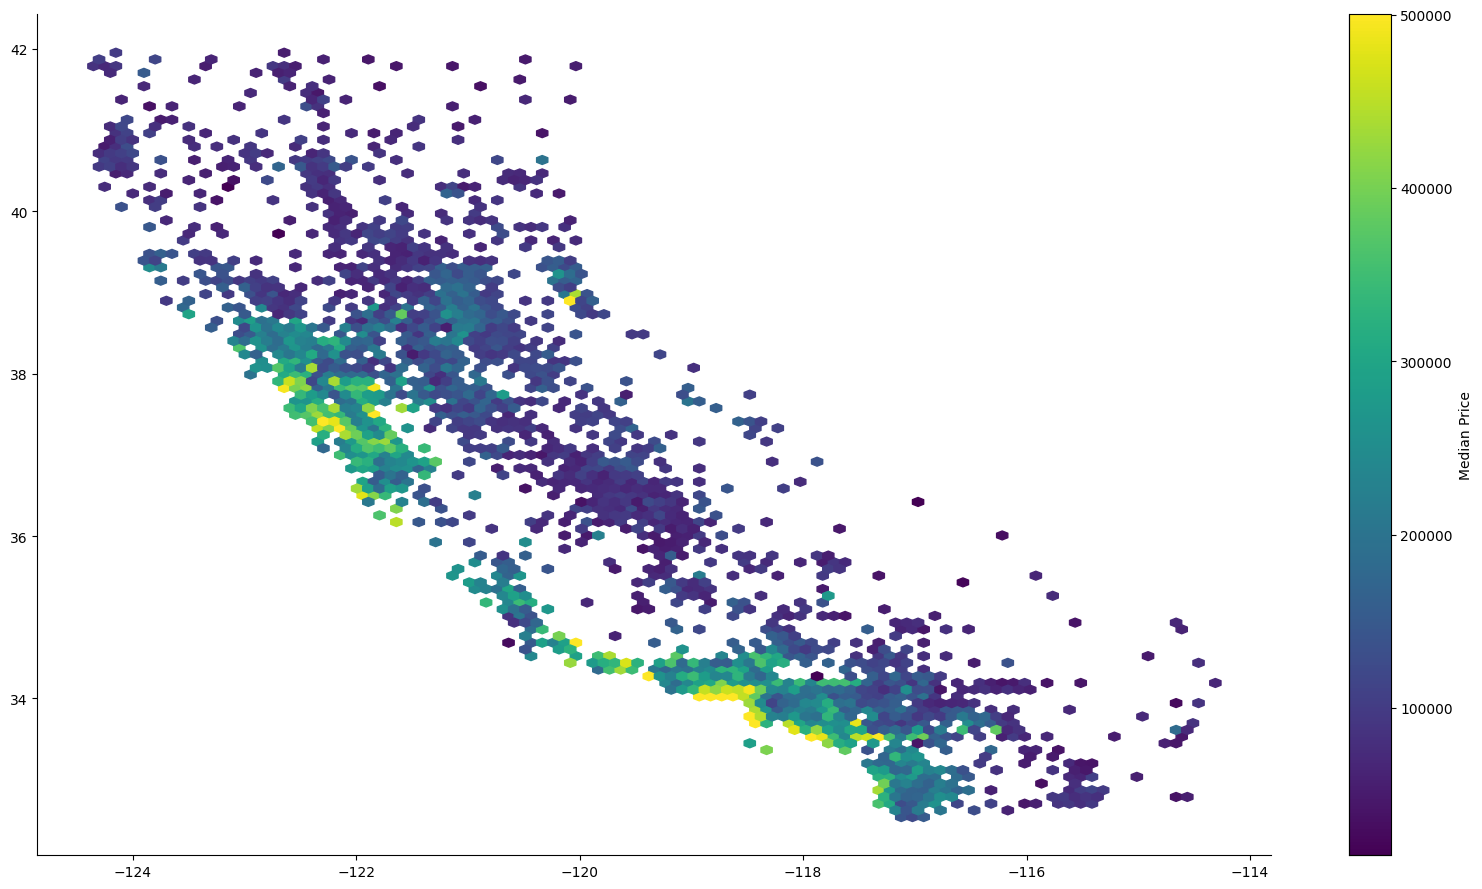

In [31]:
fig=plt.figure(figsize=(16,9))
plt.hexbin(x=df.longitude,y=df.latitude,C=df.median_house_value)
plt.colorbar(mappable=None,location='right',label="Median Price")

plt.tight_layout();
sns.despine()

In [6]:
nominal_features = list(df.drop("furnishingstatus",axis=1).select_dtypes(include="object").columns)
numeric_features = list(df.select_dtypes(exclude="object").columns)

print("\033[1mNumeric features:\033[0m")
for i,f in enumerate(numeric_features):
    if f == "price":
        print("\033[1m{}.\033[0m {} (target)".format(i+1,f))
    else:
        print("\033[1m{}.\033[0m {}".format(i+1,f))
    
print("\n\033[1mNominal features:\033[0m")
for i,f in enumerate(nominal_features):
    print("\033[1m{}.\033[0m {}: {}".format(i+1,f,df[f].unique()))

print("\n\033[1mOrdinal features:\033[0m\n\033[1m1.\033[0m furnishingstatus: {}".format(df["furnishingstatus"].unique()))

KeyError: "['furnishingstatus'] not found in axis"

Now we can go ahead with EDA.

<h2>Exploratory Data Analysis<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>

House price is our target variable.

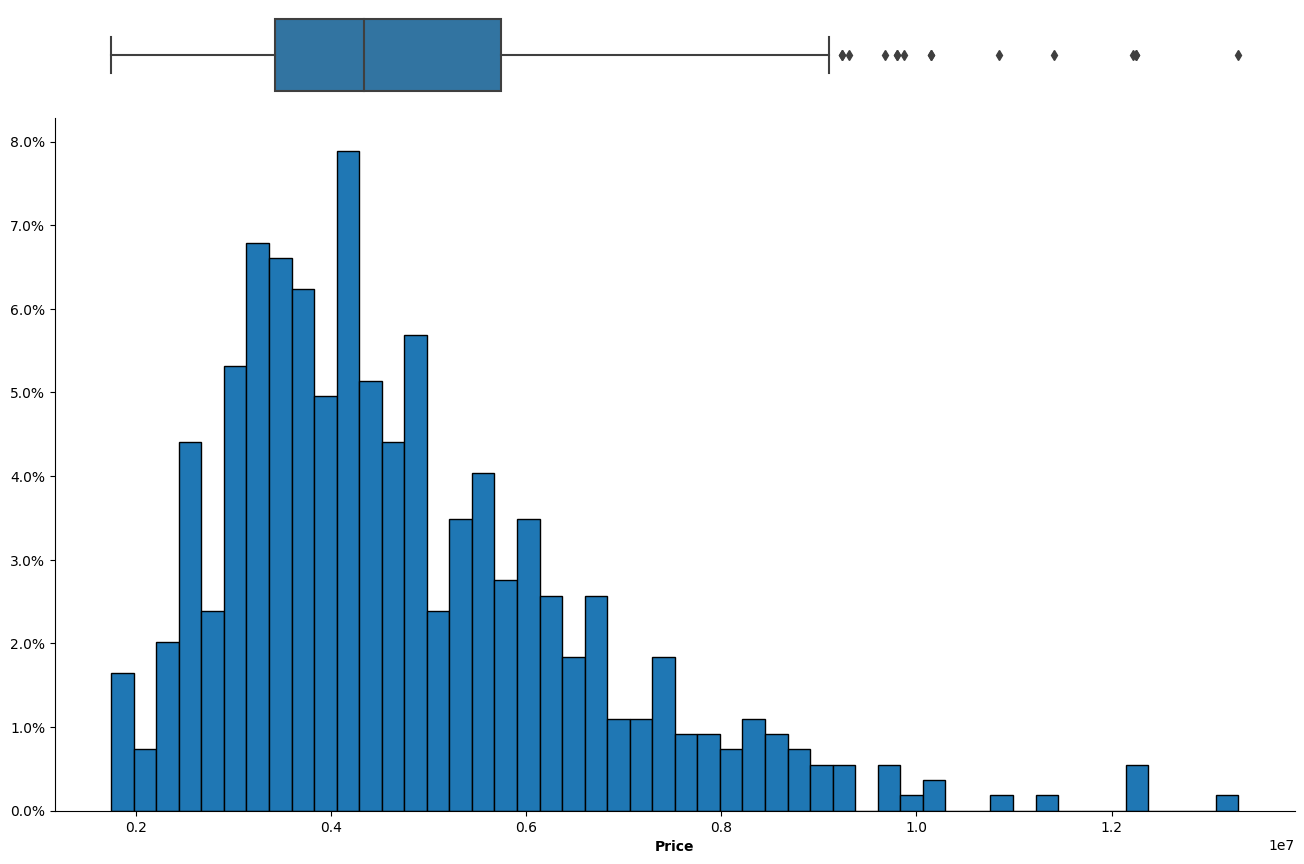

In [6]:
fig, ax_main = plt.subplots(figsize=(16,9))
ax_marginal = fig.add_axes([ax_main.get_position().x0, ax_main.get_position().y1 + 0.02,
                            ax_main.get_position().width, 0.1])

# Disegna l'istogramma sull'asse principale
h = sns.histplot(data=df, x="price", ax=ax_main, bins=50, alpha=1, stat="percent")
h.set_xlabel("Price",weight="bold")
h.set_ylabel("")
h.yaxis.set_major_formatter(PercentFormatter(100))
sns.despine()

# Disegna il boxplot sull'asse marginale
b = sns.boxplot(data=df, x="price", ax=ax_marginal, orient="h")
b.set_xlabel("")


# Rimuovi gli assi superiori e laterali
for loc in ["top","right","left","bottom"]:
    ax_marginal.spines[loc].set_visible(False)
ax_marginal.set_yticks([])
ax_marginal.set_xticks([]);

We detected some outliers, data outside the boxplot whiskers interval. Since they are just few we'll remove them during preprocessing step.

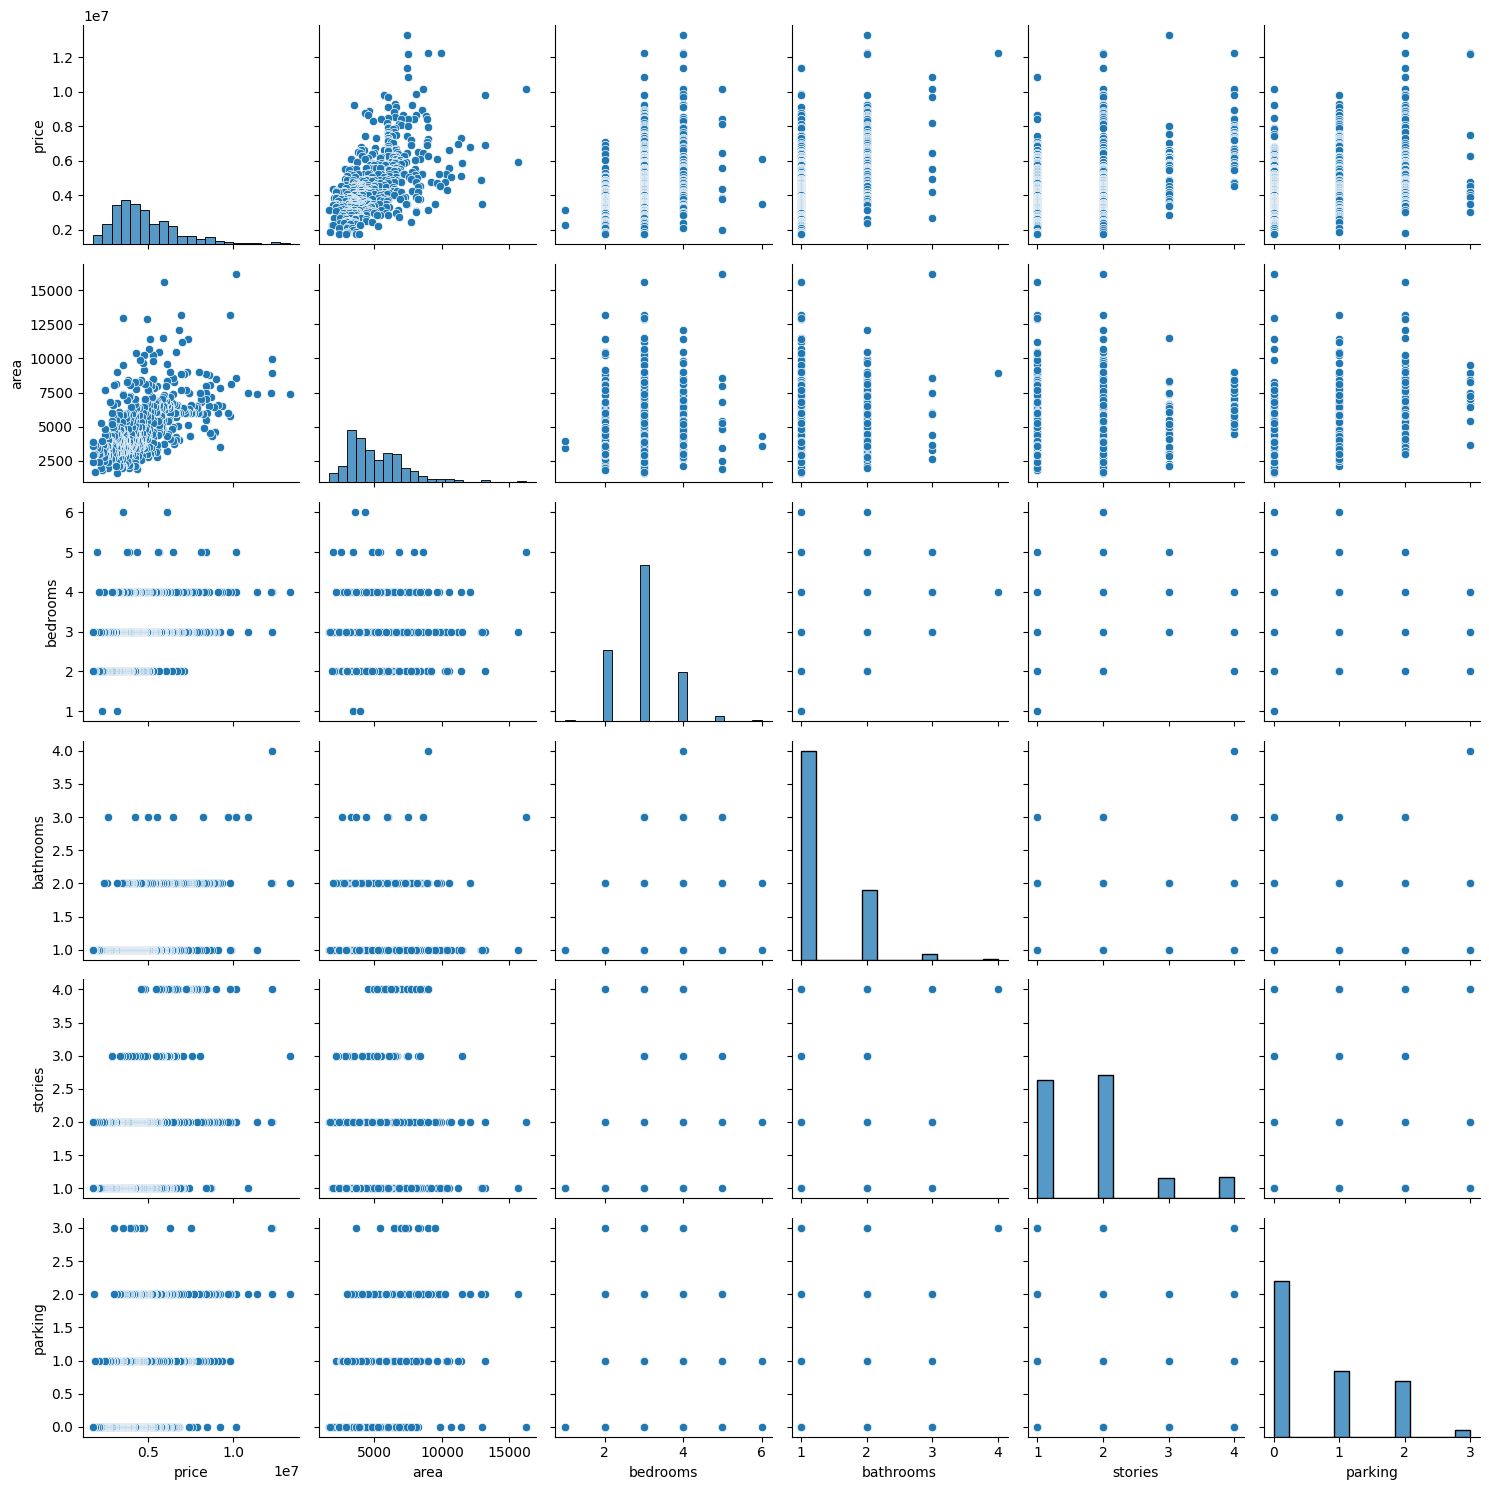

In [7]:
sns.pairplot(df[numeric_features])
plt.tight_layout();

Seems to be a positive correlation between house's area and price but correlation matrix could help us to find other ones.

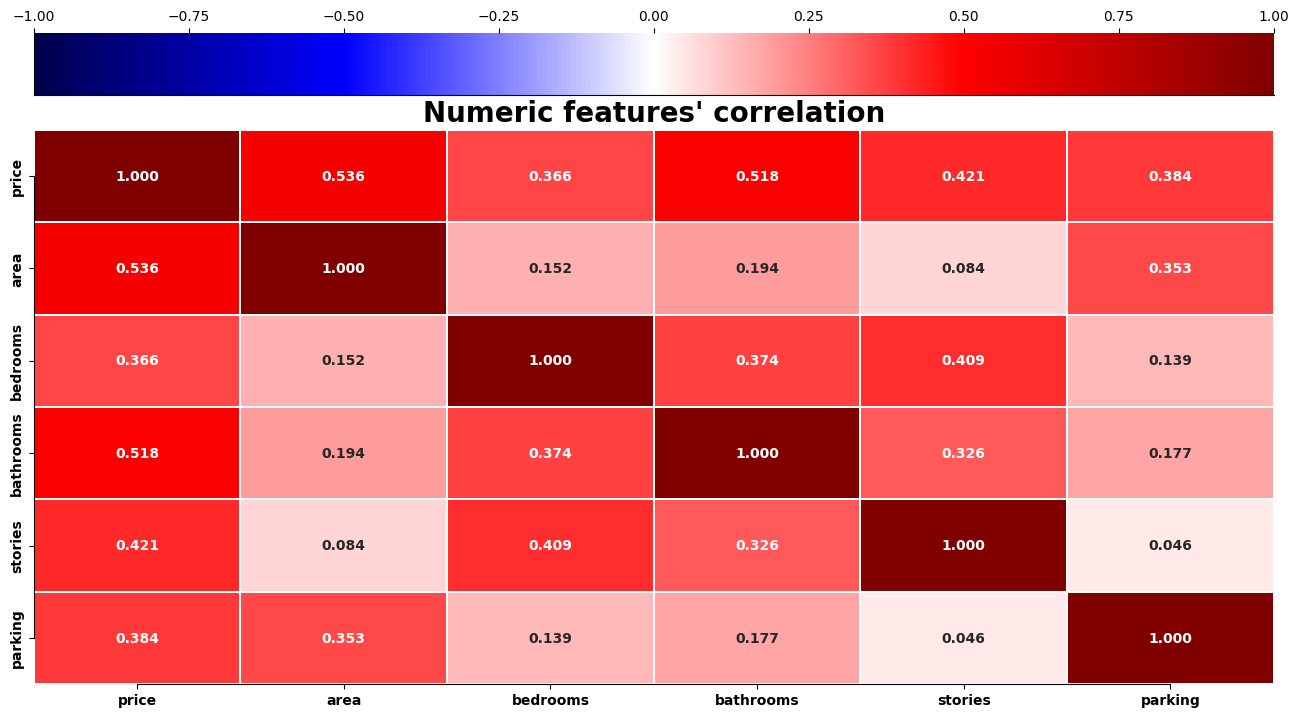

In [8]:
plt.figure(figsize=(16,9))
h = sns.heatmap(data=df.corr(),annot=True,fmt=".3f",vmin=-1,cmap="seismic",linecolor="w",linewidth=.25,
            annot_kws={"weight":"bold"},cbar_kws={"location":"top"})
h.set_yticklabels(df.corr().columns,weight="bold")
h.set_xticklabels(df.corr().columns,weight="bold")
h.set_title("Numeric features' correlation",fontsize=20,weight="bold")

sns.despine(trim=True)

Price has strong correlations with almost all features; the strongest are with both area and number of bathrooms; will be area and number of bathrooms good predictors?

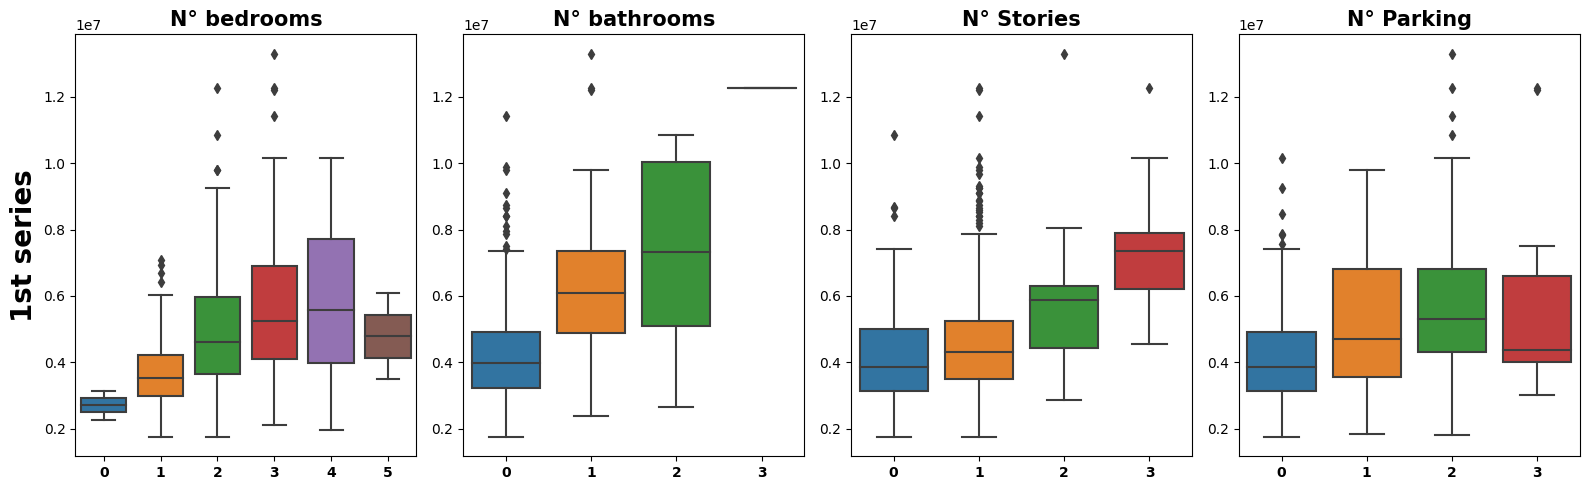

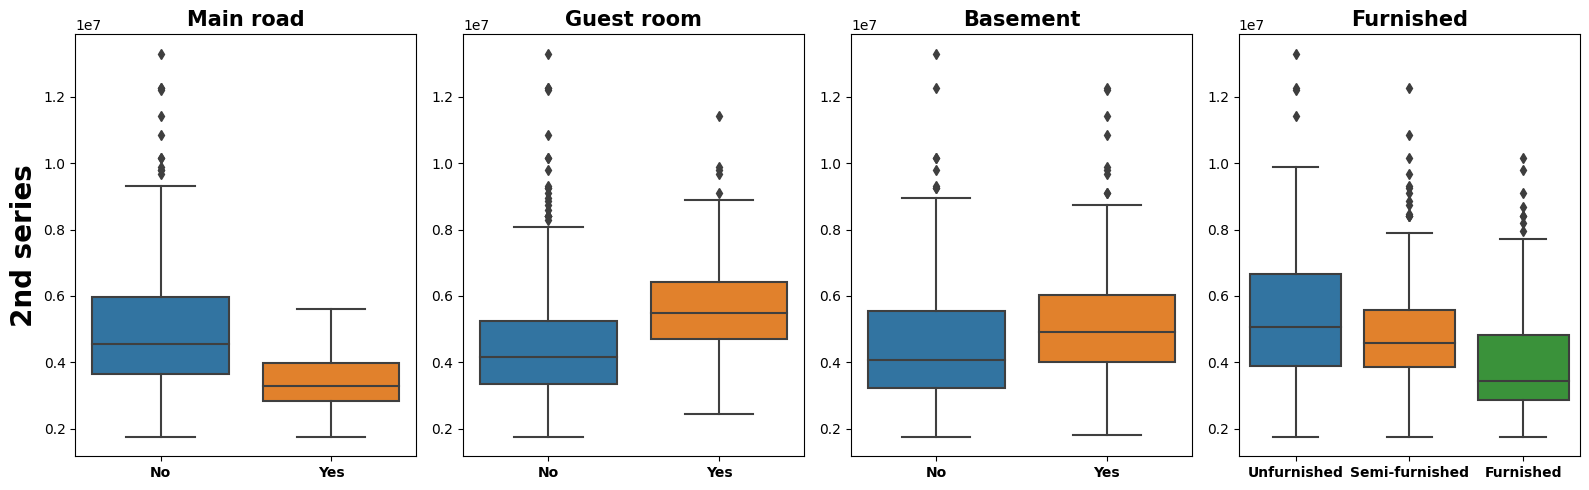

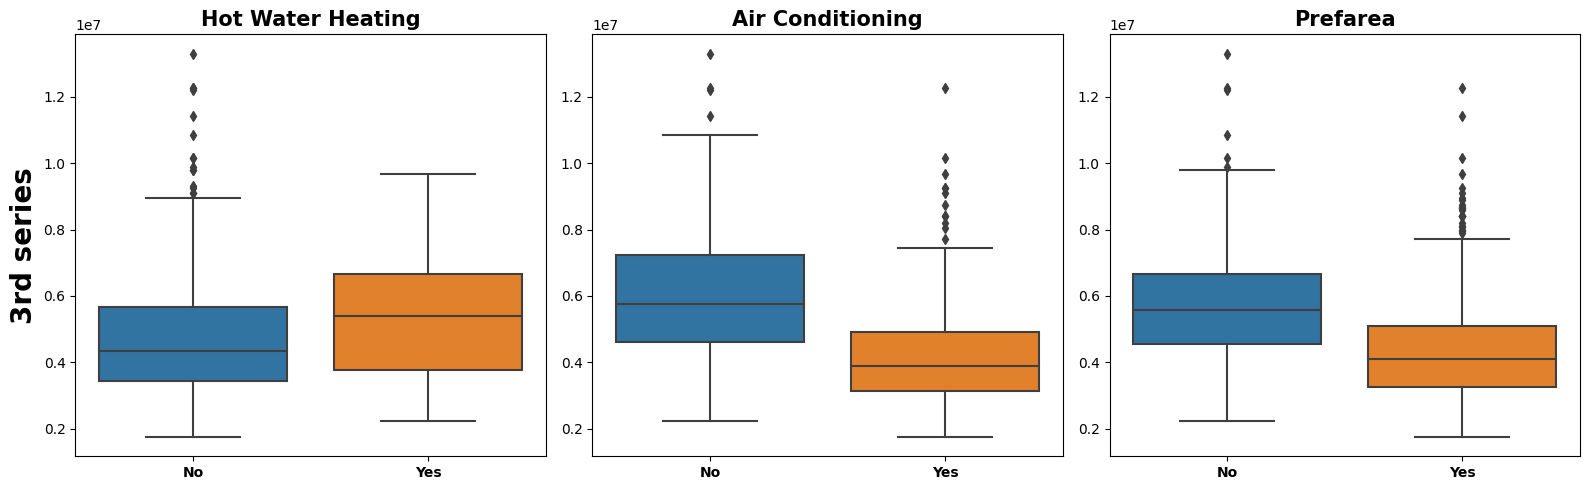

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
titles = ["N° bedrooms","N° bathrooms","N° Stories", "N° Parking"]
for index,data in enumerate(numeric_features[2:6]):
    sns.boxplot(y=df["price"],x=df[data],ax=ax[index])
    ax[index].set_xlabel("")
    if index == 0:
        ax[index].set_ylabel("1st series",weight="bold",fontsize=20)
    else:
        ax[index].set_ylabel("")
    ax[index].set_xticklabels(np.arange(len(df[data].unique())),weight="bold")
    ax[index].set_title(titles[index],weight="bold",fontsize=15)
    
    plt.tight_layout();

fig, ax = plt.subplots(1, 4, figsize=(16, 5))
titles = ["Main road","Guest room","Basement", "Furnished"]
for index,data in enumerate(["mainroad","guestroom","basement","furnishingstatus"]):
    sns.boxplot(y=df["price"],x=df[data],ax=ax[index])
    ax[index].set_xlabel("")
    if index == 0:
        ax[index].set_ylabel("2nd series",weight="bold",fontsize=20)
    else:
        ax[index].set_ylabel("")
    if data != "furnishingstatus":
        ax[index].set_xticklabels(["No","Yes"],weight="bold")
    else:
        ax[index].set_xticklabels(["Unfurnished","Semi-furnished","Furnished"],weight="bold")
    ax[index].set_title(titles[index],weight="bold",fontsize=15)
    
    plt.tight_layout();

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
titles = ["Hot Water Heating","Air Conditioning","Prefarea"]
for index,data in enumerate(nominal_features[3:6]):
    sns.boxplot(y=df["price"],x=df[data],ax=ax[index])
    ax[index].set_xlabel("")
    if index == 0:
        ax[index].set_ylabel("3rd series",weight="bold",fontsize=20)
    else:
        ax[index].set_ylabel("")
    ax[index].set_xticklabels(["No","Yes"],weight="bold")
    ax[index].set_title(titles[index],weight="bold",fontsize=15)
    
    plt.tight_layout();

1st series: the most bedrooms, bathrooms, stories and parkings leads to higher price.

2nd series: being furnished as well as the presence of main road, guest room and basement means higher price.

3rd series: same pattern as 2nd series: if there is it you have to pay more.

<h2>Preprocessing<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>

First outliers will be dropped: every instance with a price too high or too low.

Different preprocessing for different kind of variables:

1) Numeric variables: standardized (x-mean)/std

2) Nominal variables (everything except "Furnishing status"): one hot encoded

3) Ordinal variable ("Furnishing status"): label encoded to preserve ordinal relation between level

In [6]:
Q1 = np.percentile(df["price"],25)
Q3 = np.percentile(df["price"],75)

IQR = Q3-Q1

lower = Q1-1.5*IQR
upper = Q3+1.5*IQR

for index, row in df.iterrows():
    if row['price'] < lower or row['price'] > upper:
        df.drop(index, inplace=True)
df = df.reset_index().drop("index",axis=1)
print("After outlier removal dataframe has \033[1m{}\033[0m rows".format(df.shape[0]))

After outlier removal dataframe has 530 rows


In [7]:
df["furnishingstatus"] = df["furnishingstatus"].map({"furnished":2, "semi-furnished":1, "unfurnished":0})
df["furnishingstatus"].head(10)

0    1
1    0
2    2
3    2
4    1
5    1
6    0
7    2
8    2
9    2
Name: furnishingstatus, dtype: int64

In [8]:
X = df.drop("price",axis=1) #Features
y = df.price #Target

numeric_features.remove("price")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = .5, random_state=0)

set_names = ["Train","Validation","Test"]
print("\033[1mTrain size:\033[0m {} instances, {:.2%} of the total.".format(X_train.shape[0],X_train.shape[0]/X.shape[0]))
print("\033[1mVal size:\033[0m {} instances, {:.2%} of the total.".format(X_val.shape[0],X_val.shape[0]/X.shape[0]))
print("\033[1mTest size:\033[0m {} instances, {:.2%} of the total.\n".format(X_test.shape[0],X_test.shape[0]/X.shape[0]))
for index,y in enumerate([y_train, y_val, y_test]):
    print("\033[1m{} target:\033[0m mean {:.2e}, std {:.2e}, min {}, max {}".
          format(set_names[index],np.mean(y),np.std(y),np.min(y),np.max(y)))
    
#Selecting features for different processing
X_num_train = X_train[numeric_features]
X_num_val = X_val[numeric_features]
X_num_test = X_test[numeric_features]

X_nom_train = X_train.drop("furnishingstatus",axis=1)[nominal_features]
X_nom_val = X_val.drop("furnishingstatus",axis=1)[nominal_features]
X_nom_test = X_test.drop("furnishingstatus",axis=1)[nominal_features]

X_ord_train = X_train["furnishingstatus"].values.reshape(-1, 1)
X_ord_val = X_val["furnishingstatus"].values.reshape(-1, 1)
X_ord_test = X_test["furnishingstatus"].values.reshape(-1, 1)

#Scaling numerical features...
scl = StandardScaler()
X_num_train = scl.fit_transform(X_num_train)
X_num_val = scl.transform(X_num_val)
X_num_test = scl.transform(X_num_test)

#...encoding nominal features
ohe = OneHotEncoder(sparse=False)
X_nom_train = ohe.fit_transform(X_nom_train)
X_nom_val = ohe.transform(X_nom_val)
X_nom_test = ohe.transform(X_nom_test)

#Assembling processed sets
X_train = np.concatenate([X_num_train, X_nom_train, X_ord_train], axis=1)
X_val = np.concatenate([X_num_val, X_nom_val, X_ord_val], axis=1)
X_test = np.concatenate([X_num_test, X_nom_test, X_ord_test], axis=1)

print("\nSets features: {}".format(X_train.shape[1]))

Train size: 371 instances, 70.00% of the total.
Val size: 79 instances, 14.91% of the total.
Test size: 80 instances, 15.09% of the total.

Train target: mean 4.63e+06, std 1.57e+06, min 1820000, max 9100000
Validation target: mean 4.62e+06, std 1.66e+06, min 1750000, max 9100000
Test target: mean 4.45e+06, std 1.61e+06, min 1750000, max 8645000

Sets features: 18


<h2>Modeling<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>

6 regressors, Linear Regression, Decision Tree, K Nearest Neighbors, Support Vector Machine, Ridge and Lasso, will be fitted in thier default form using Mean Squared Error as metric to evaluate performances.

Mean and median of the target will be used as baselines to evaluate model's performance.

**Selecting best models**

In [13]:
#Models
lr = LinearRegression(positive=True)
dt = DecisionTreeRegressor(random_state=0)
knr = KNeighborsRegressor()
svr = SVR()
ridge = Ridge(positive=True,random_state=0)
lasso = Lasso(positive=True,random_state=0)

models = [lr,dt,knr,svr,ridge,lasso]
names = ["Mean","Median","LR","DT","KNR","SVR","Ridge","Lasso"]
scores = []
    
mean_val = np.empty(len(y_val))
for i in range(len(y_val)):
    mean_val[i] = np.mean(y_val)
median_val = np.empty(len(y_val))
for i in range(len(y_val)):
    median_val[i] = np.median(y_val)
scores.append(mean_squared_error(y_val,mean_val))
scores.append(mean_squared_error(y_val,median_val))
    
for index,model in enumerate(models):
    model.fit(X_train,y_train)
    scores.append(mean_squared_error(y_val,model.predict(X_val)))
print("Models' MSE:\n")
for index,name in enumerate(names):
    print("\033[1m{}:\033[0m {:.2f}".format(name,scores[index]))

Models' MSE:

Mean: 2769232201009.45
Median: 2948509408227.85
LR: 1188812928336.02
DT: 1546736636075.95
KNR: 1159034277215.19
SVR: 2849515156065.66
Ridge: 1190609574385.89
Lasso: 1188814801138.52


Good! Since every model outperformed baselines we'll select only top 3 models based on MSE: Linear Regression, KNeighbors and Lasso.

2 error metrics, MSE and RMSE, and 2 variance metrics, Explained Variance and R2, are used to evalute how the models fit the data.

In [14]:
#Training models on the whole train set
lr = LinearRegression(positive=True)
knr = KNeighborsRegressor()
lasso = Lasso(positive=True,random_state=0)

models = [lr,knr,lasso]
for model in tqdm(models,desc="Fitting"):
    model.fit(X_train,y_train)

#Getting predictions on validation set
lr_pred = lr.predict(X_val)
knr_pred = knr.predict(X_val)
lasso_pred = lasso.predict(X_val)

#Metrics
#Train
lr_mse_train = mean_squared_error(y_train,lr.predict(X_train),squared=True)
lr_rmse_train = mean_squared_error(y_train,lr.predict(X_train),squared=False)
lr_ev_train = explained_variance_score(y_train,lr.predict(X_train))
lr_r2_train = r2_score(y_train,lr.predict(X_train))
lr_train_metrics = np.array([lr_mse_train,lr_rmse_train,lr_ev_train,lr_r2_train])

knr_mse_train = mean_squared_error(y_train,knr.predict(X_train),squared=True)
knr_rmse_train = mean_squared_error(y_train,knr.predict(X_train),squared=False)
knr_ev_train = explained_variance_score(y_train,knr.predict(X_train))
knr_r2_train = r2_score(y_train,knr.predict(X_train))
knr_train_metrics = np.array([knr_mse_train,knr_rmse_train,knr_ev_train,knr_r2_train])

lasso_mse_train = mean_squared_error(y_train,lasso.predict(X_train),squared=True)
lasso_rmse_train = mean_squared_error(y_train,lasso.predict(X_train),squared=False)
lasso_ev_train = explained_variance_score(y_train,lasso.predict(X_train))
lasso_r2_train = r2_score(y_train,lasso.predict(X_train))
lasso_train_metrics = np.array([lasso_mse_train,lasso_rmse_train,lasso_ev_train,lasso_r2_train])

train_metrics = pd.DataFrame(np.concatenate([lr_train_metrics,knr_train_metrics,lasso_train_metrics]).reshape(3,4),
                            columns=["MSE","RMSE","EV","R2"],index=["LR","knr","Lasso"])
train_preds = np.array([lr.predict(X_train),knr.predict(X_train),lasso.predict(X_train)])

#Test
lr_mse_val = mean_squared_error(y_val,lr_pred,squared=True)
lr_rmse_val = mean_squared_error(y_val,lr_pred,squared=False)
lr_ev_val = explained_variance_score(y_val,lr_pred)
lr_r2_val = r2_score(y_val,lr_pred)
lr_val_metrics = np.array([lr_mse_val,lr_rmse_val,lr_ev_val,lr_r2_val])

knr_mse_val = mean_squared_error(y_val,knr_pred,squared=True)
knr_rmse_val = mean_squared_error(y_val,knr_pred,squared=False)
knr_ev_val = explained_variance_score(y_val,knr_pred)
knr_r2_val = r2_score(y_val,knr_pred)
knr_val_metrics = np.array([knr_mse_val,knr_rmse_val,knr_ev_val,knr_r2_val])

lasso_mse_val = mean_squared_error(y_val,lasso_pred,squared=True)
lasso_rmse_val = mean_squared_error(y_val,lasso_pred,squared=False)
lasso_ev_val = explained_variance_score(y_val,lasso_pred)
lasso_r2_val = r2_score(y_val,lasso_pred)
lasso_val_metrics = np.array([lasso_mse_val,lasso_rmse_val,lasso_ev_val,lasso_r2_val])

val_metrics = pd.DataFrame(np.concatenate([lr_val_metrics,knr_val_metrics,lasso_val_metrics]).reshape(3,4),
                            columns=["MSE","RMSE","EV","R2"],index=["LR","knr","Lasso"])
val_preds = np.array([lr.predict(X_val),knr.predict(X_val),lasso.predict(X_val)])

Fitting:   0%|          | 0/3 [00:00<?, ?it/s]

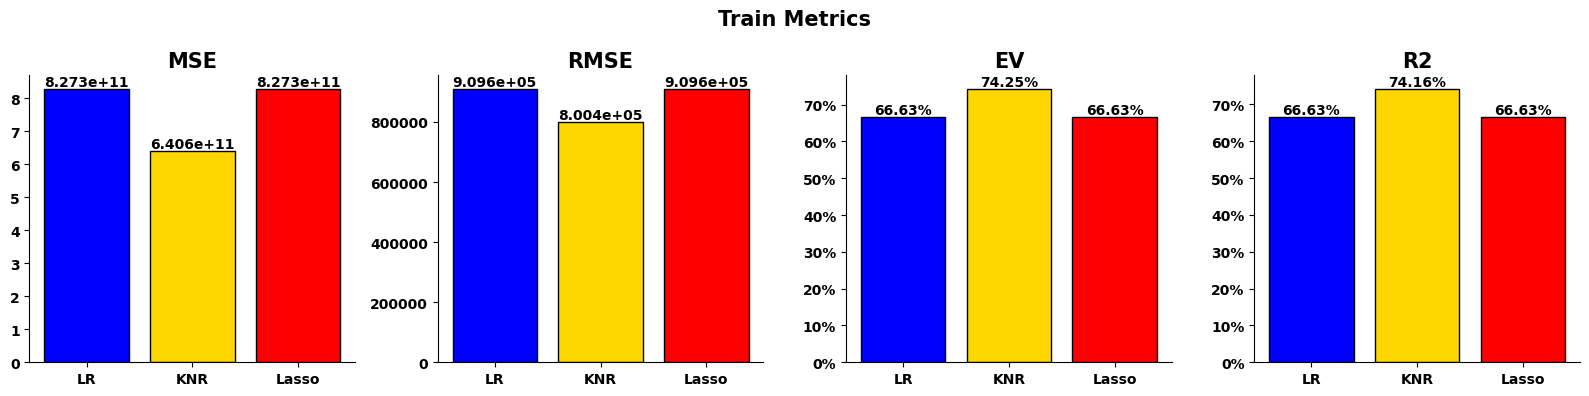

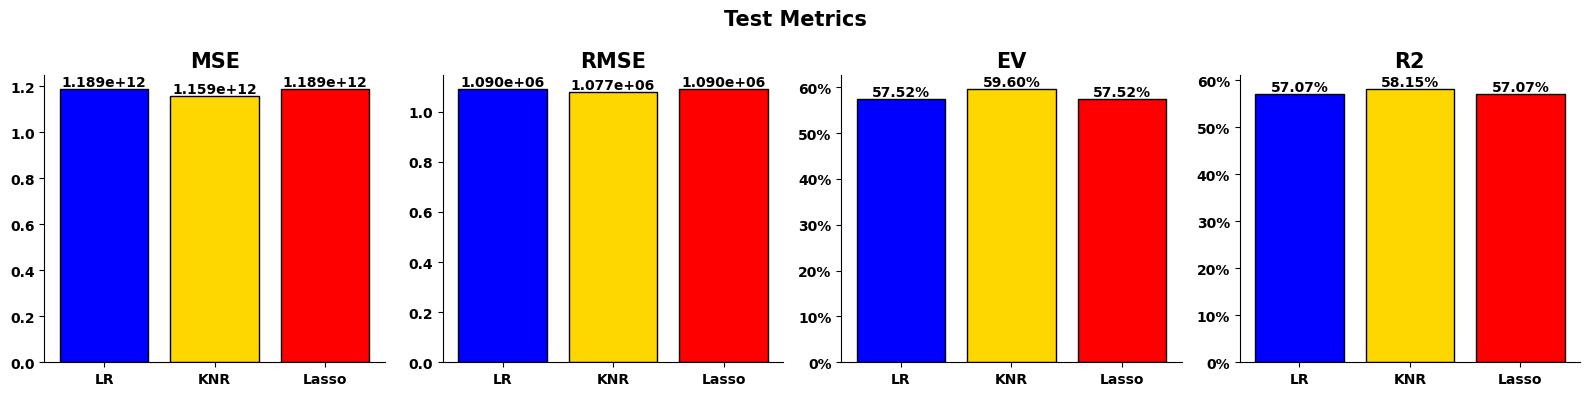

In [15]:
#Comparing model metrics with baselines for all sets
formatter = PercentFormatter(xmax=1.0)
title = ["Train","Test"]
for index,s in enumerate([train_metrics,val_metrics]):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i in np.arange(4):
        ax[i].bar(data=s,x=s.index,height=s.iloc[:,i],color=["blue","gold","red"],edgecolor="k")
        ax[i].set_title(str(s.columns[i]),weight="bold",fontsize=15)
        ax[i].set_xticklabels(["LR","KNR","Lasso"],weight="bold")
        ax[i].set_yticklabels(ax[i].get_yticklabels(),fontproperties={"weight":"bold"})
        ax[i].set_ylabel("")
        fig.suptitle((title[index]+" Metrics"),weight="bold",fontsize=15)
        if s.columns[i] == "EV" or s.columns[i] == "R2":
            ax[i].yaxis.set_major_formatter(PercentFormatter(1))
            for p in ax[i].patches:
                ax[i].annotate(format(p.get_height(), '.2%'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',weight="bold")
        else:
            for p in ax[i].patches:
                ax[i].annotate(format(p.get_height(), '.3e'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',weight="bold")
        sns.despine()
        plt.tight_layout();

They're very similar, but KNR seems to be slightly better.

Let's take a look at how true values and predictions overlap.

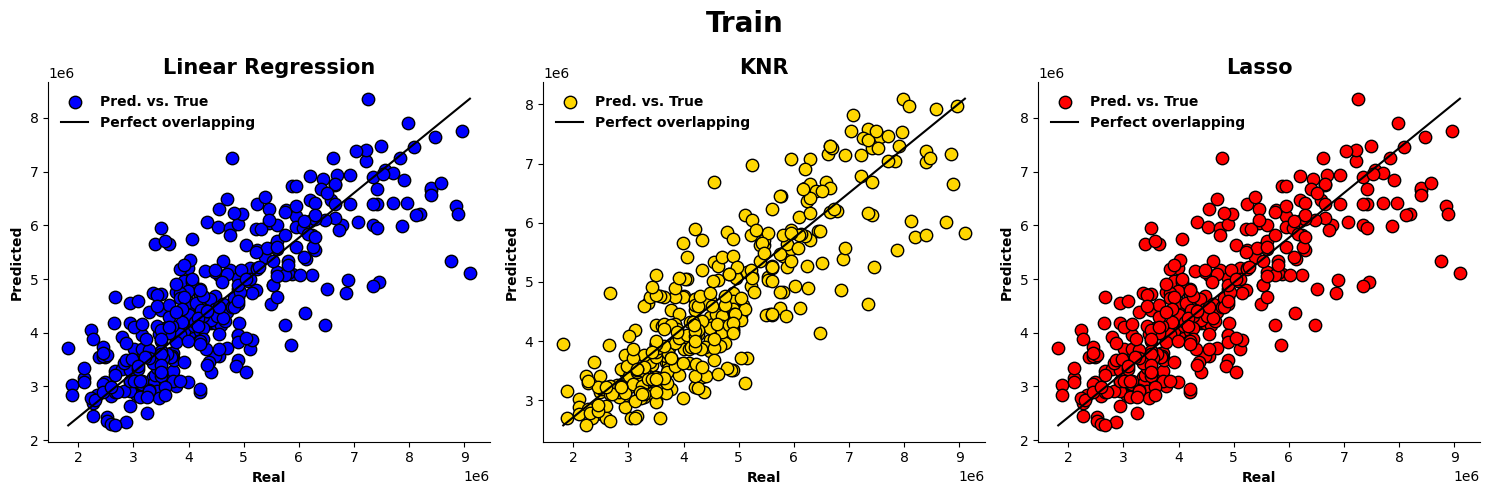

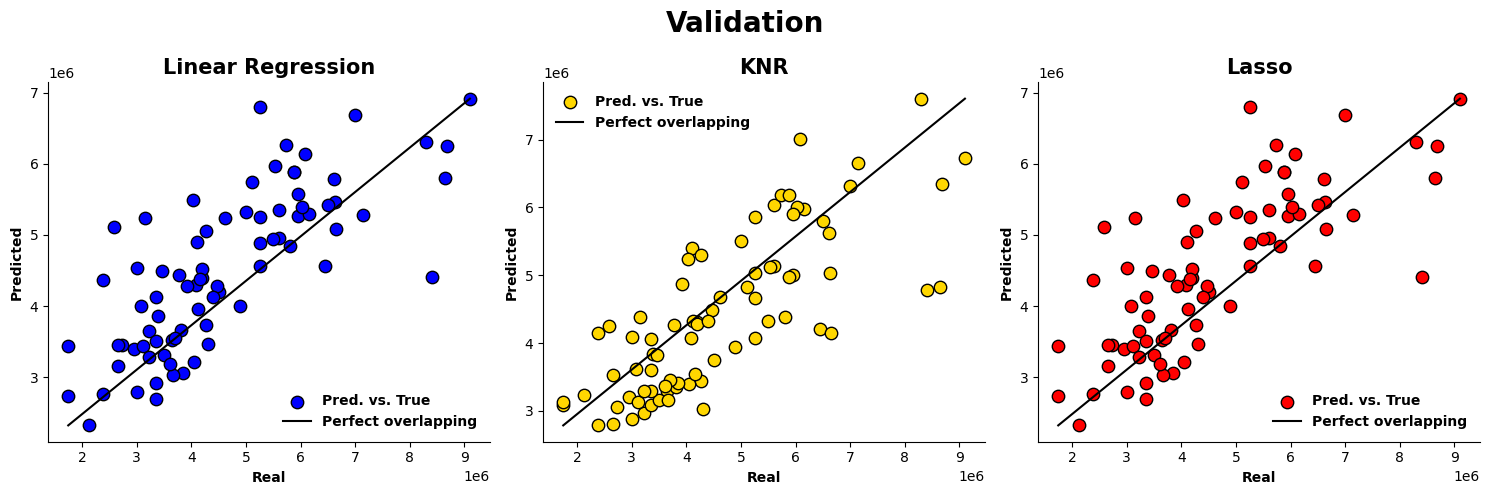

In [16]:
formatter = PercentFormatter(xmax=1.0)
title = ["Train","Validation"]
names = ["Linear Regression", "KNR", "Lasso"]
colors = ["blue","gold","red"]
for index,s in enumerate([train_preds,val_preds]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in np.arange(3):
        if index == 0:
            ax[i].scatter(y_train,train_preds[i],c=colors[i],edgecolor="k",s=80,label="Pred. vs. True")
            ax[i].plot([min(y_train),max(y_train)],[min(train_preds[i]),max(train_preds[i])],c="k",label="Perfect overlapping")
        else:
            ax[i].scatter(y_val,val_preds[i],c=colors[i],edgecolor="k",s=80,label="Pred. vs. True")
            ax[i].plot([min(y_val),max(y_val)],[min(val_preds[i]),max(val_preds[i])],c="k",label="Perfect overlapping")
        ax[i].set_xlabel("Real",weight="bold")
        ax[i].set_ylabel("Predicted",weight="bold")
        ax[i].set_title(names[i],weight="bold",fontsize=15)
        ax[i].legend(prop={"weight":"bold"},frameon=False)
        fig.suptitle(title[index],weight="bold",fontsize=20)
    sns.despine()
    plt.tight_layout();

<h2>Tuning<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>

Optuna library will be used to find best hyperparameters combination for best models.

A sampler and a percentile pruner, best 1% trials, will be used just to explore best combination of hyperparameters.

**KNeighbors Regressor**

In [26]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

def objective(trial):
    neighbors = trial.suggest_int("n_neighbors",2,len(X_train))
    weight = trial.suggest_categorical("weights",["uniform","distance"])
    alg = trial.suggest_categorical("algorithm",["auto","ball_tree","kd_tree","brute"])
    P = trial.suggest_int("p",1,2)

    model= KNeighborsRegressor(n_neighbors=neighbors,
                               weights=weight,
                               algorithm=alg,
                               p=P,
                               n_jobs=-1)
    model.fit(X_train,y_train)
    ev = explained_variance_score(y_val,model.predict(X_val))

    return ev

ridge_study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=0),
                                pruner=optuna.pruners.PercentilePruner(1.0))
ridge_study.optimize(objective, n_trials=5000,show_progress_bar=True,n_jobs=-1,gc_after_trial=True)
print("Explained Variance: {:.2%}".format(ridge_study.best_trial.value))
print(ridge_study.best_trial.params)

  0%|          | 0/5000 [00:00<?, ?it/s]

Explained Variance: 61.41%
{'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}


**Lasso Regressor**

In [27]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

def objective(trial):
    a = trial.suggest_loguniform("alpha",0.000001,10)
    select = trial.suggest_categorical("selection",["cyclic","random"])
    m_iter = trial.suggest_int("max_iter",1000,50000,step=10)
    tolerance = trial.suggest_loguniform("tol",0.000000001,10)
    pos = trial.suggest_categorical("positive",[True,False])

    model= Lasso(alpha=a,
                 selection=select,
                 max_iter=m_iter,
                 tol=tolerance,
                 positive=pos,
                 random_state=0)
    model.fit(X_train,y_train)
    ev = explained_variance_score(y_val,model.predict(X_val))

    return ev

lasso_study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=0),
                                pruner=optuna.pruners.PercentilePruner(1.0))
lasso_study.optimize(objective, n_trials=5000,show_progress_bar=True,n_jobs=-1,gc_after_trial=True)
print("Explained Variance: {:.2%}".format(lasso_study.best_trial.value))
print(lasso_study.best_trial.params)

  0%|          | 0/5000 [00:00<?, ?it/s]

Explained Variance: 62.15%
{'alpha': 1.000334966393366e-06, 'selection': 'random', 'max_iter': 26060, 'tol': 0.682137173042549, 'positive': True}


In [17]:
#Training models on the whole train set
#Linear Regression already fitted
knr_gold = KNeighborsRegressor(n_neighbors=6,
                               weights="uniform",
                               algorithm="brute",
                               p=1,
                               n_jobs=-1)
lasso_gold = Lasso(alpha=1.000334966393366e-06,
                   selection="random",
                   max_iter=26060,
                   tol=0.682137173042549,
                   positive=True,
                   random_state=0)

models = [lr,knr_gold,lasso_gold]
for model in tqdm(models,desc="Fitting"):
    model.fit(X_train,y_train)

#Getting predictions on validation set
lr_pred = lr.predict(X_val)
knr_gold_pred = knr_gold.predict(X_val)
lasso_gold_pred = lasso_gold.predict(X_val)

#Metrics
#Train
lr_mse_train = mean_squared_error(y_train,lr.predict(X_train),squared=True)
lr_rmse_train = mean_squared_error(y_train,lr.predict(X_train),squared=False)
lr_ev_train = explained_variance_score(y_train,lr.predict(X_train))
lr_r2_train = r2_score(y_train,lr.predict(X_train))
lr_train_metrics = np.array([lr_mse_train,lr_rmse_train,lr_ev_train,lr_r2_train])

knr_gold_mse_train = mean_squared_error(y_train,knr_gold.predict(X_train),squared=True)
knr_gold_rmse_train = mean_squared_error(y_train,knr_gold.predict(X_train),squared=False)
knr_gold_ev_train = explained_variance_score(y_train,knr_gold.predict(X_train))
knr_gold_r2_train = r2_score(y_train,knr_gold.predict(X_train))
knr_gold_train_metrics = np.array([knr_gold_mse_train,knr_gold_rmse_train,knr_gold_ev_train,knr_gold_r2_train])

lasso_gold_mse_train = mean_squared_error(y_train,lasso_gold.predict(X_train),squared=True)
lasso_gold_rmse_train = mean_squared_error(y_train,lasso_gold.predict(X_train),squared=False)
lasso_gold_ev_train = explained_variance_score(y_train,lasso_gold.predict(X_train))
lasso_gold_r2_train = r2_score(y_train,lasso_gold.predict(X_train))
lasso_gold_train_metrics = np.array([lasso_gold_mse_train,lasso_gold_rmse_train,lasso_gold_ev_train,lasso_gold_r2_train])

train_gold_metrics = pd.DataFrame(np.concatenate([lr_train_metrics,knr_gold_train_metrics,lasso_gold_train_metrics]).reshape(3,4),
                            columns=["MSE","RMSE","EV","R2"],index=["LR","knr","Lasso"])
train_gold_preds = np.array([lr.predict(X_train),knr_gold.predict(X_train),lasso_gold.predict(X_train)])

#Validation
lr_mse_val = mean_squared_error(y_val,lr_pred,squared=True)
lr_rmse_val = mean_squared_error(y_val,lr_pred,squared=False)
lr_ev_val = explained_variance_score(y_val,lr_pred)
lr_r2_val = r2_score(y_val,lr_pred)
lr_val_metrics = np.array([lr_mse_val,lr_rmse_val,lr_ev_val,lr_r2_val])

knr_gold_mse_val = mean_squared_error(y_val,knr_gold_pred,squared=True)
knr_gold_rmse_val = mean_squared_error(y_val,knr_gold_pred,squared=False)
knr_gold_ev_val = explained_variance_score(y_val,knr_gold_pred)
knr_gold_r2_val = r2_score(y_val,knr_gold_pred)
knr_gold_val_metrics = np.array([knr_gold_mse_val,knr_gold_rmse_val,knr_gold_ev_val,knr_gold_r2_val])

lasso_gold_mse_val = mean_squared_error(y_val,lasso_gold_pred,squared=True)
lasso_gold_rmse_val = mean_squared_error(y_val,lasso_gold_pred,squared=False)
lasso_gold_ev_val = explained_variance_score(y_val,lasso_gold_pred)
lasso_gold_r2_val = r2_score(y_val,lasso_gold_pred)
lasso_gold_val_metrics = np.array([lasso_gold_mse_val,lasso_gold_rmse_val,lasso_gold_ev_val,lasso_gold_r2_val])

val_gold_metrics = pd.DataFrame(np.concatenate([lr_val_metrics,knr_gold_val_metrics,lasso_gold_val_metrics]).reshape(3,4),
                            columns=["MSE","RMSE","EV","R2"],index=["LR","knr","Lasso"])
val_gold_preds = np.array([lr.predict(X_val),knr_gold.predict(X_val),lasso_gold.predict(X_val)])

Fitting:   0%|          | 0/3 [00:00<?, ?it/s]

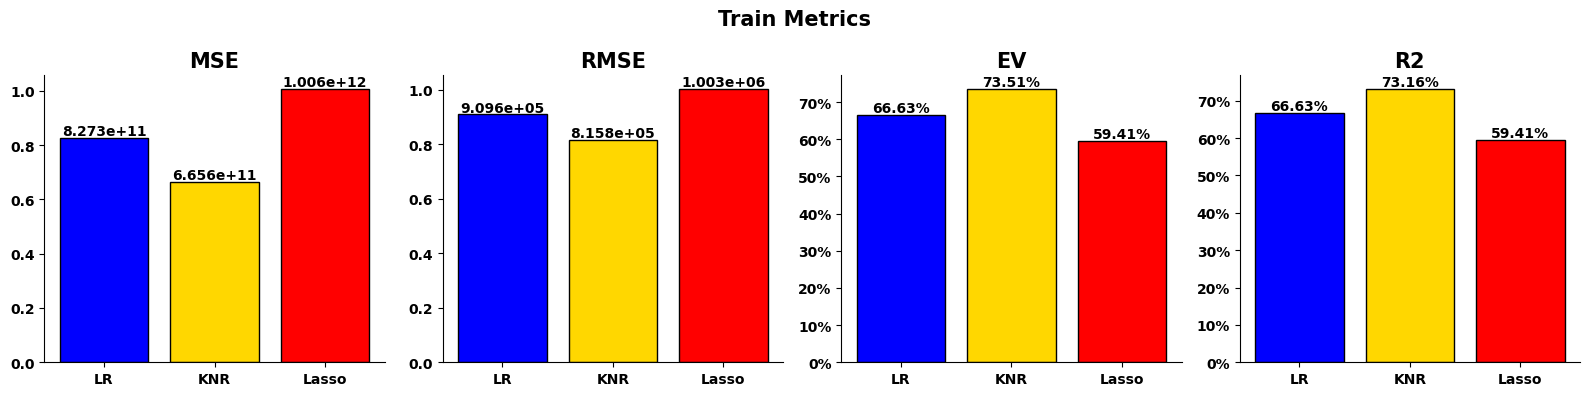

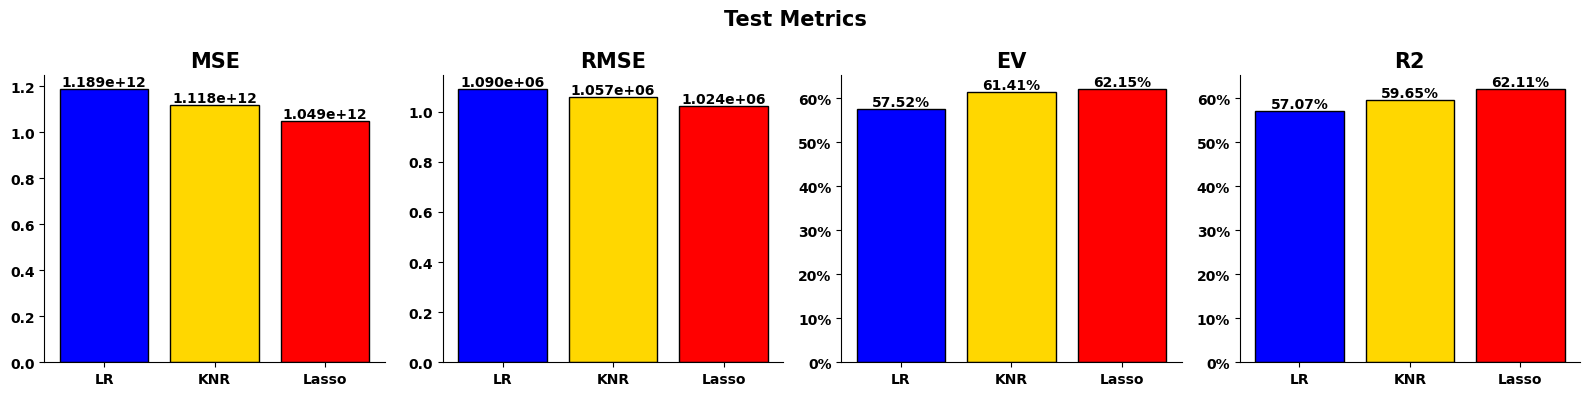

In [18]:
#Comparing model metrics with baselines for all sets
formatter = PercentFormatter(xmax=1.0)
title = ["Train","Test"]
for index,s in enumerate([train_gold_metrics,val_gold_metrics]):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for i in np.arange(4):
        ax[i].bar(data=s,x=s.index,height=s.iloc[:,i],color=["blue","gold","red"],edgecolor="k")
        ax[i].set_title(str(s.columns[i]),weight="bold",fontsize=15)
        ax[i].set_xticklabels(["LR","KNR","Lasso"],weight="bold")
        ax[i].set_yticklabels(ax[i].get_yticklabels(),fontproperties={"weight":"bold"})
        ax[i].set_ylabel("")
        fig.suptitle((title[index]+" Metrics"),weight="bold",fontsize=15)
        if s.columns[i] == "EV" or s.columns[i] == "R2":
            ax[i].yaxis.set_major_formatter(PercentFormatter(1))
            for p in ax[i].patches:
                ax[i].annotate(format(p.get_height(), '.2%'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',weight="bold")
        else:
            for p in ax[i].patches:
                ax[i].annotate(format(p.get_height(), '.3e'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',weight="bold")
        sns.despine()
        plt.tight_layout();

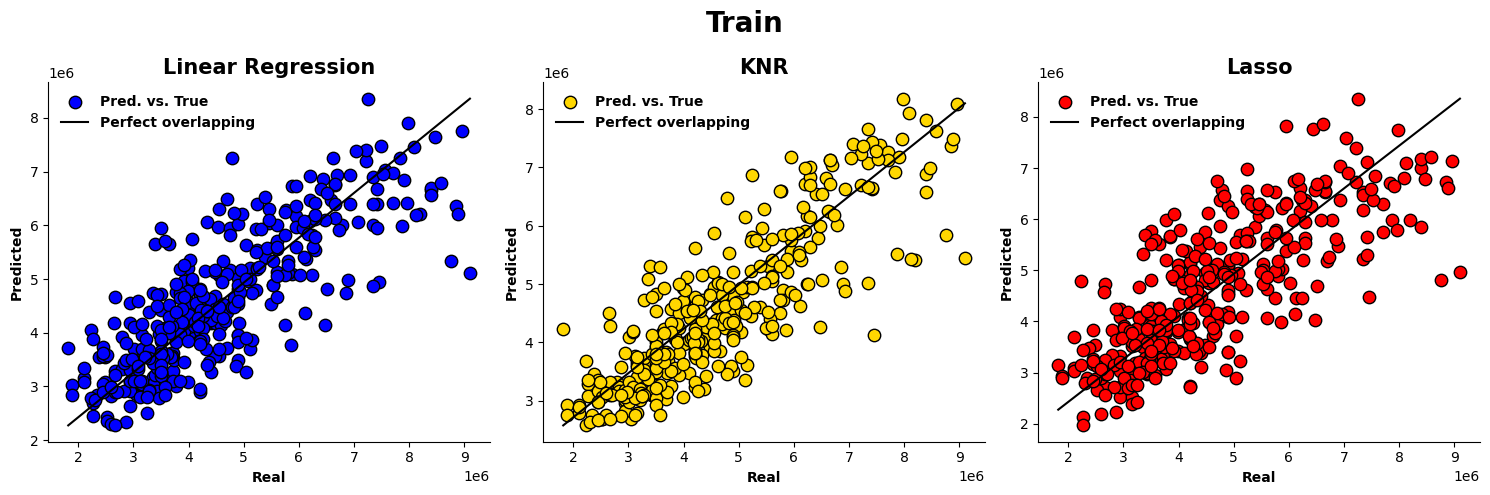

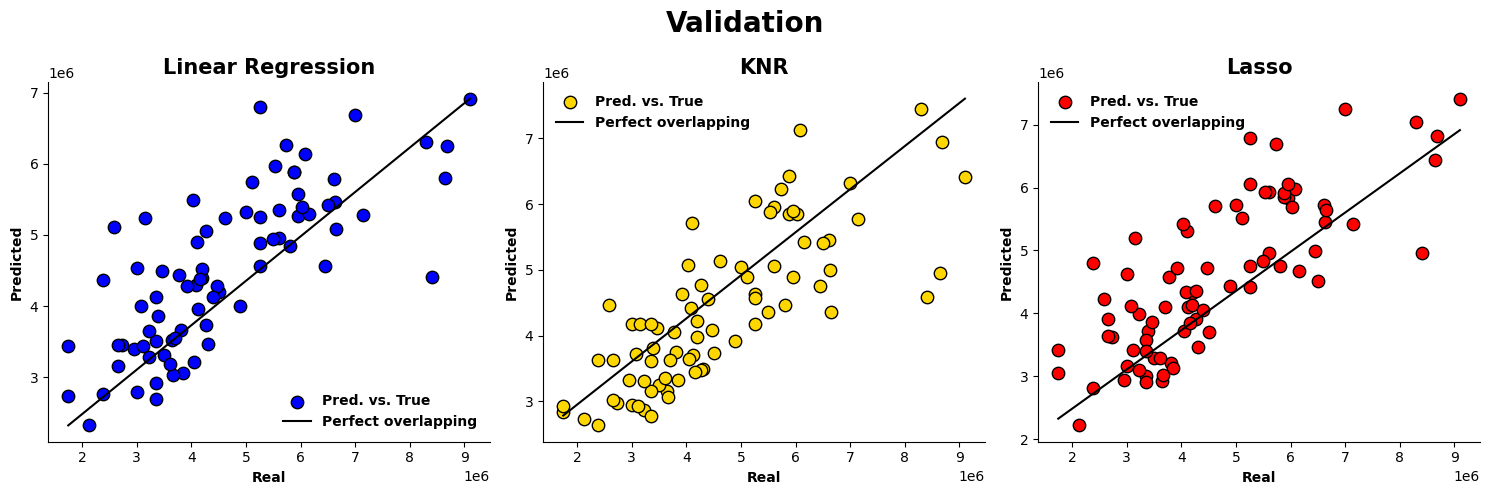

In [19]:
formatter = PercentFormatter(xmax=1.0)
title = ["Train","Validation"]
names = ["Linear Regression", "KNR", "Lasso"]
colors = ["blue","gold","red"]
for index,s in enumerate([train_gold_preds,val_gold_preds]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in np.arange(3):
        if index == 0:
            ax[i].scatter(y_train,s[i],c=colors[i],edgecolor="k",s=80,label="Pred. vs. True")
            ax[i].plot([min(y_train),max(y_train)],[min(train_preds[i]),max(train_preds[i])],c="k",label="Perfect overlapping")
        else:
            ax[i].scatter(y_val,s[i],c=colors[i],edgecolor="k",s=80,label="Pred. vs. True")
            ax[i].plot([min(y_val),max(y_val)],[min(val_preds[i]),max(val_preds[i])],c="k",label="Perfect overlapping")
        ax[i].set_xlabel("Real",weight="bold")
        ax[i].set_ylabel("Predicted",weight="bold")
        ax[i].set_title(names[i],weight="bold",fontsize=15)
        ax[i].legend(prop={"weight":"bold"},frameon=False)
        fig.suptitle(title[index],weight="bold",fontsize=20)
    sns.despine()
    plt.tight_layout();

<h2>Ensemble<span class="tocSkip"></span></h2>
<div class="toc"><ul class="toc-item"></ul></div>